# Problem : Wine Quality Predictions

- **Task:** Predict the quality of wine based on the chemical compositions.

In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

print(f"{sys.version=}")
print(f"{np.__version__=}")
print(f"{torch.__version__=}")

sys.version='3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:28:53) [Clang 19.1.7 ]'
np.__version__='2.3.4'
torch.__version__='2.8.0'


# Data Engineering

In [2]:
import csv
wine_path = "../data/winequality-white.csv"

with open(wine_path, 'r') as f:
    reader = csv.reader(f, delimiter=';')
    col_list = next(reader)
col_list

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [3]:
# Data
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
                         skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]],
      shape=(4898, 12), dtype=float32)

In [4]:
wineq = torch.from_numpy(wineq_numpy)
wineq.shape

torch.Size([4898, 12])

# Feature Engineering

In [5]:
x = wineq[:, :-1]
y = wineq[:, -1].unsqueeze(1)
x.shape, y.shape

(torch.Size([4898, 11]), torch.Size([4898, 1]))

In [6]:
unique_labels = y.unique()
unique_labels

tensor([3., 4., 5., 6., 7., 8., 9.])

In [7]:
# Simple Train/val split (80/20)
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_val, y_val = x[split:], y[split:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([3918, 11]),
 torch.Size([3918, 1]),
 torch.Size([980, 11]),
 torch.Size([980, 1]))

In [8]:
def normalize(tensor, mean=None, std=None):
    if mean is None:
        mean = tensor.mean(0, keepdim=True)
    if std is None:
        std = tensor.std(0, keepdim=True)
    tensor = (tensor - mean) / std
    return tensor, mean, std

In [9]:
#normalize
x_train, mean, std = normalize(x_train)
print(f"{mean =}, {std =}")
x_train[:5]


mean =tensor([[6.9631e+00, 2.7591e-01, 3.4140e-01, 6.3671e+00, 4.5569e-02, 3.5570e+01,
         1.4068e+02, 9.9421e-01, 3.1931e+00, 4.8868e-01, 1.0457e+01]]), std =tensor([[8.4499e-01, 1.0052e-01, 1.2298e-01, 5.1033e+00, 2.1928e-02, 1.6969e+01,
         4.3406e+01, 2.9944e-03, 1.5322e-01, 1.1430e-01, 1.2144e+00]])


tensor([[ 0.0437, -0.0588,  0.1512,  2.8085, -0.0259,  0.5557,  0.6754,  2.2689,
         -1.2606, -0.3384, -1.3642],
        [-0.7847,  0.2397, -0.0114, -0.9341,  0.1565, -1.2711, -0.2001, -0.0688,
          0.6974,  0.0115, -0.7878],
        [ 1.3455,  0.0407,  0.4765,  0.1044,  0.2021, -0.3282, -1.0064,  0.2986,
          0.4363, -0.4259, -0.2937],
        [ 0.2804, -0.4567, -0.1740,  0.4179,  0.5669,  0.6736,  1.0440,  0.4655,
         -0.0205, -0.7759, -0.4584],
        [ 0.2804, -0.4567, -0.1740,  0.4179,  0.5669,  0.6736,  1.0440,  0.4655,
         -0.0205, -0.7759, -0.4584]])

In [10]:
#normalize
x_val, _, _ = normalize(x_val, mean, std)
print(f"{mean =}, {std =}")
x_val[:5]


mean =tensor([[6.9631e+00, 2.7591e-01, 3.4140e-01, 6.3671e+00, 4.5569e-02, 3.5570e+01,
         1.4068e+02, 9.9421e-01, 3.1931e+00, 4.8868e-01, 1.0457e+01]]), std =tensor([[8.4499e-01, 1.0052e-01, 1.2298e-01, 5.1033e+00, 2.1928e-02, 1.6969e+01,
         4.3406e+01, 2.9944e-03, 1.5322e-01, 1.1430e-01, 1.2144e+00]])


tensor([[-0.6664,  0.7371, -0.4993, -0.9341, -0.3908, -0.2693, -0.6378, -2.1427,
         -0.4774, -0.7759,  3.0826],
        [-0.4297,  0.3391, -0.4993, -0.9733, -0.4820, -0.4461, -0.7760, -1.9523,
         -1.2606, -0.7759,  2.2591],
        [ 0.5170, -0.2578,  0.2325, -0.7382,  0.2021, -0.6818, -0.2001, -0.9438,
         -0.9995,  0.3615,  0.6121],
        [ 0.3987,  0.8365, -0.0114,  1.6524,  0.5213,  0.6147,  0.7445,  1.1034,
         -0.3469,  0.7114, -0.2113],
        [-0.3114,  0.3391, -0.3366, -0.7773, -0.3452, -0.3282, -1.3290, -1.8488,
         -0.6732, -1.1258,  1.9297]])

# Model

In [11]:
x.size(1)

11

In [12]:

model = nn.Sequential(
            nn.Linear(11, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
            )

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()

n_epochs = 500

train_loss_list = []
val_loss_list = []
for epoch in range(n_epochs):
    outputs = model(x_train)
    loss = loss_fn(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = model(x_val)
        val_loss = loss_fn(outputs, y_val)
    if epoch % 100 == 0 or epoch == n_epochs - 1:
        print("Epoch: %d, Train Loss: %f, Validation Loss: %f" % (epoch, float(loss), float(val_loss)))
    train_loss_list.append(float(loss))
    val_loss_list.append(float(val_loss))

    

/var/folders/js/_k136j9d7gg6wnt5qljgw61r0000gq/T/ipykernel_66319/1421874667.py:32: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1760285604563/work/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print("Epoch: %d, Train Loss: %f, Validation Loss: %f" % (epoch, float(loss), float(val_loss)))


Epoch: 0, Train Loss: 35.983425, Validation Loss: 32.845928
Epoch: 100, Train Loss: 0.701042, Validation Loss: 0.587276
Epoch: 200, Train Loss: 0.540105, Validation Loss: 0.425816
Epoch: 300, Train Loss: 0.512907, Validation Loss: 0.411510
Epoch: 400, Train Loss: 0.501035, Validation Loss: 0.408841
Epoch: 499, Train Loss: 0.492835, Validation Loss: 0.406845


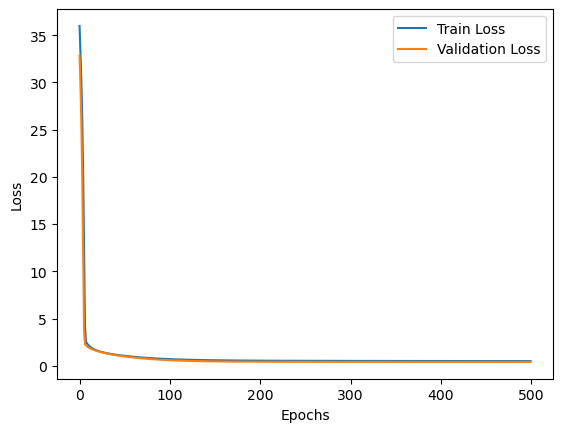

In [13]:
#plotting loss curves
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()